In [184]:
# UNCOMMENT first with internet option turned on
# Use GPU env

# !pip download tabpfn --no-deps -d pip-packages

# from tabpfn import TabPFNClassifier
# TabPFNClassifier(N_ensemble_configurations = 64, device = 'cuda:0')

# !mv /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/prior_diff_real_checkpoint_n_0_epoch_100.cpkt pip-packages/
# !zip -r pip-packages.zip pip-packages

# now you need to download the zip and upload it as dataset with the plus in the top left
# then you need to add it to the notebook as data on the right, and name it `pip-packages-icr`

# now you can turn internet off and still install, like below

In [185]:
# !pip install tabpfn --no-index --find-links=file:///kaggle/input/pip-packages-icr/pip-packages

In [186]:
# !mkdir -p /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff
# !cp /kaggle/input/pip-packages-icr/pip-packages/prior_diff_real_checkpoint_n_0_epoch_100.cpkt /opt/conda/lib/python3.10/site-packages/tabpfn/models_diff/

In [187]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import pickle
from pyprojroot import here

from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler, Normalizer, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error, silhouette_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, HistGradientBoostingClassifier, StackingClassifier, VotingClassifier

from tabpfn import TabPFNClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier, XGBRegressor

from imblearn.over_sampling import ADASYN, SMOTE

import warnings
warnings.filterwarnings('ignore')


### Data Pull

In [188]:
# load data
local_dir = str(here()) + '/'
kaggle_dir = '/kaggle/input/'
train_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/train.csv')
test_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/test.csv')
greeks_df = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/greeks.csv')

y_train_splitter = pd.read_csv(local_dir + 'icr-identify-age-related-conditions/y_train_splitter.csv', index_col = 0)

# join greeks and add Epsilon
train_df.drop(['EJ'], axis = 1, inplace = True)
train_df = pd.merge(train_df, greeks_df, on = 'Id')
train_df = train_df.drop(['Id'], axis = 1)
train_df['Epsilon'] = train_df['Epsilon'].replace('Unknown', np.nan)
train_df_nan = train_df[train_df['Epsilon'].isna()]
train_df = train_df[train_df['Epsilon'].notna()]
train_df['Epsilon'] = pd.to_datetime(train_df['Epsilon'])
train_df['Epsilon'] = train_df['Epsilon'].apply(lambda x: x.toordinal() - 734640)
train_df.reset_index(drop = True, inplace = True)
train_df = pd.concat([train_df, train_df_nan], axis = 0, ignore_index = True)
train_df.columns = train_df.columns.str.strip()

# Data Pre-Processing

In [189]:
# fix outliers
def clip_outliers(df):
    df_out = df.copy()
    df_out['AY'].clip(upper = 0.625, inplace = True)
    df_out['AH'].clip(upper = 550, inplace = True)
    df_out['AR'].clip(upper = 60, inplace = True)
    df_out['AX'].clip(upper = 18, inplace = True)
    df_out['BC'].clip(upper = 100, inplace = True)
    df_out['BD'].clip(upper = 20000, inplace = True)
    df_out['BR'].clip(upper = 5250, inplace = True)
    df_out['BZ'].clip(upper = 5000, inplace = True)
    df_out['CB'].clip(upper = 800, inplace = True)
    df_out['CF'].clip(upper = 50, inplace = True)
    df_out['CL'].clip(upper = 10, inplace = True)
    df_out['DF'].clip(upper = 10, inplace = True)
    df_out['DU'].clip(upper = 25, inplace = True)
    df_out['DV'].clip(upper = 10, inplace = True)
    df_out['EB'].clip(upper = 40, inplace = True)
    df_out['EG'].clip(upper = 10000, inplace = True)
    df_out['EH'].clip(upper = 2, inplace = True)
    df_out['EP'].clip(upper = 250, inplace = True)
    df_out['EU'].clip(upper = 300, inplace = True)
    df_out['FC'].clip(upper = 500, inplace = True)
    df_out['FE'].clip(upper = 7500, inplace = True)
    df_out['FD'].clip(upper = 50, inplace = True)
    df_out['FR'].clip(upper = 10, inplace = True)
    df_out['FS'].clip(upper = 2, inplace = True)
    df_out['Epsilon'].clip(lower = 2000, inplace = True)
    
    return df_out

In [190]:
# set random seed
random_seed = 101010
np.random.seed(random_seed)

# create x and y train
X_train = train_df.drop(['Alpha', 'Beta', 'Delta', 'Gamma', 'Class'], axis = 1, inplace = False)
y_train_class = train_df['Class']

y_encoder = LabelEncoder()
y_train_alpha = y_encoder.fit_transform(train_df['Alpha'])
y_train_beta = y_encoder.fit_transform(train_df['Beta'])
y_train_delta = y_encoder.fit_transform(train_df['Delta'])
y_train_gamma = y_encoder.fit_transform(train_df['Gamma'])

In [191]:
# impute data
# X_train = clip_outliers(X_train)
knn_imputer = KNNImputer(n_neighbors = 10, weights = 'distance')
imputed = knn_imputer.fit_transform(X_train)
X_train = pd.DataFrame(imputed, columns = X_train.columns, index = X_train.index)

In [192]:
# plot styles
font_dict_header = {'size': 20, 'weight': 'bold'}
font_dict_axistitle = {'size': 14, 'weight': 'bold'}

In [193]:
# features tiered by importance
tier_1_features = ['EP', 'CR', 'AY', 'AB', 'DU', 'DA', 'DI', 'DH', 'BC', 'DL', 'EE', 'BQ', 'BN']
tier_2_features = ['EG', 'DY', 'FD', 'AX', 'FR', 'FC', 'EL', 'DE', 'EU', 'FI', 'CS', 'EH', 'EB', 'CC', 'GL', 'FL', 'CU', 'AF']
tier_3_features = ['AH', 'AM', 'AR', 'AZ', 'BD', 'BP', 'BR', 'BZ', 'CB', 'CD', 'CF', 'CH', 'CL', 'CW', 'DF', 'DN', 'DV', 'FE', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI']
all_features = tier_1_features + tier_2_features + tier_3_features

# EDA

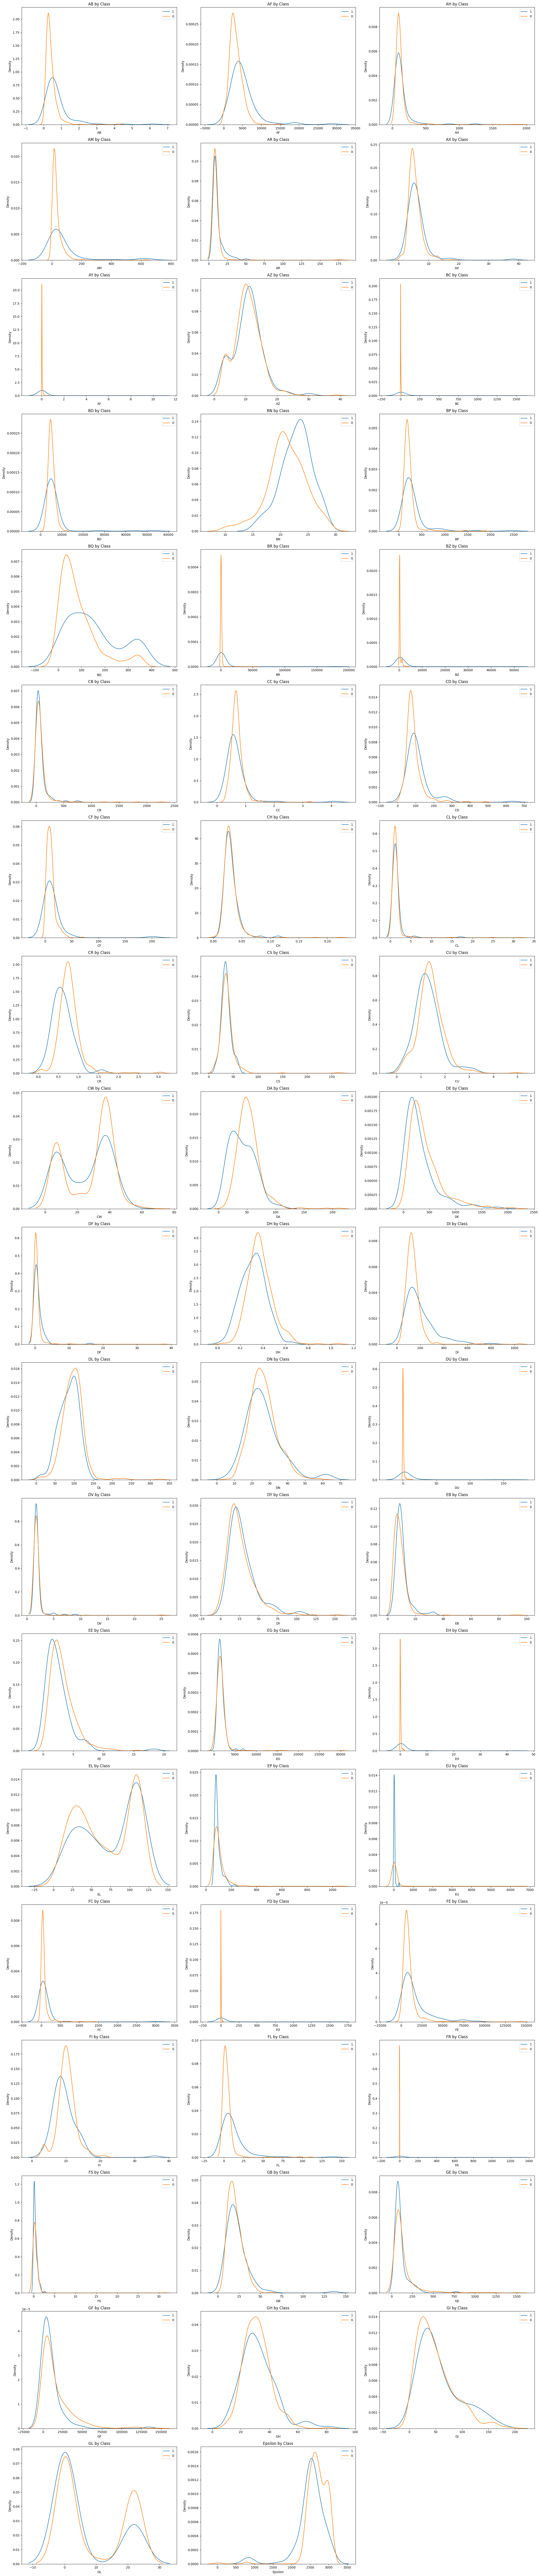

In [194]:
responses = [y_train_class]
features = X_train.columns
n_features = len(features)
n_cols = 3  # number of plots per row
n_rows = math.ceil(n_features / n_cols)  # rows needed per response

# Creating a figure for each response
for response in responses:
    df_1 = X_train[response == 1]
    df_0 = X_train[response == 0]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
    axes = axes.ravel()  # flatten the axes array

    for j, feature in enumerate(features):
        ax = axes[j]  # select the current axis
        ax.set_title(f'{feature} by {response.name}')
        sns.kdeplot(df_1[feature], label = '1', ax = ax)
        sns.kdeplot(df_0[feature], label = '0', ax = ax)
        ax.legend()

    # remove the empty subplots
    for i in range(n_features, n_cols * n_rows):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

## TSNE

In [195]:
class_color_map = {0: 'C0', 1: 'C1'}
alpha_color_map = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3'}
cluster_map = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6', 7: 'C7', 8: 'C8', 9: 'C9'}
error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C2', 'False Negative': 'C3'}

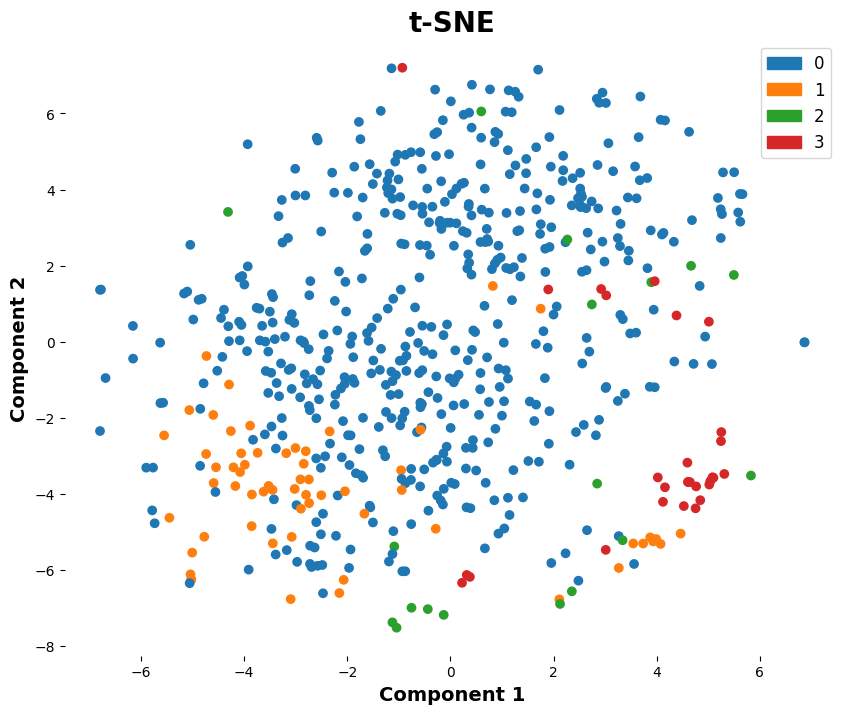

In [196]:
tsne_n = 2
tsne_df = X_train.drop(['Epsilon'], axis = 1, inplace = False)
tsne_scaled = StandardScaler().fit_transform(tsne_df)
tsne_transformed = PowerTransformer().fit_transform(tsne_scaled)
tsne_df = pd.DataFrame(tsne_transformed, columns = tsne_df.columns, index = tsne_df.index)
tsne = TSNE(n_components = tsne_n, perplexity = 100, random_state = random_seed) 
tsne_columns = ['Component ' + str(i + 1) for i in range(tsne_n)]
X_tsne = tsne.fit_transform(tsne_df)

# create df with the t-SNE components and 'Class'
tsne_df = pd.DataFrame(data = X_tsne, columns = tsne_columns)
tsne_df['Class'] = y_train_class
tsne_df['Alpha'] = y_train_alpha

colors = tsne_df['Alpha'].map(alpha_color_map)

legend_elements = [Patch(color = clr, label = lbl) for lbl, clr in alpha_color_map.items()]

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors)
plt.legend(handles = legend_elements, loc = 'upper right', fontsize = 12)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()

### KMeans Clustering from TSNE

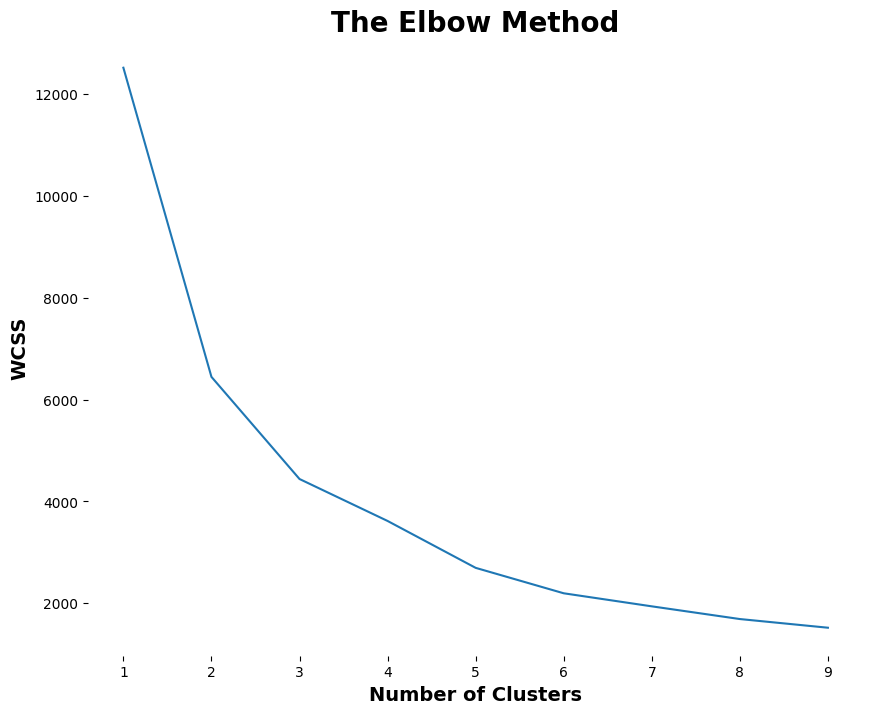

In [197]:
kmeans_df = tsne_df[tsne_columns]
range_clusters = range(1, 10)
wcss = []
for i in range_clusters:
    kmeans = KMeans(n_clusters = i, n_init = 'auto', random_state = random_seed)
    kmeans.fit(kmeans_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (10, 8))
plt.title('The Elbow Method', fontdict = font_dict_header)
plt.box(False)
plt.plot(range_clusters, wcss)
plt.xlabel('Number of Clusters', fontdict = font_dict_axistitle)
plt.ylabel('WCSS', fontdict = font_dict_axistitle)

plt.show()

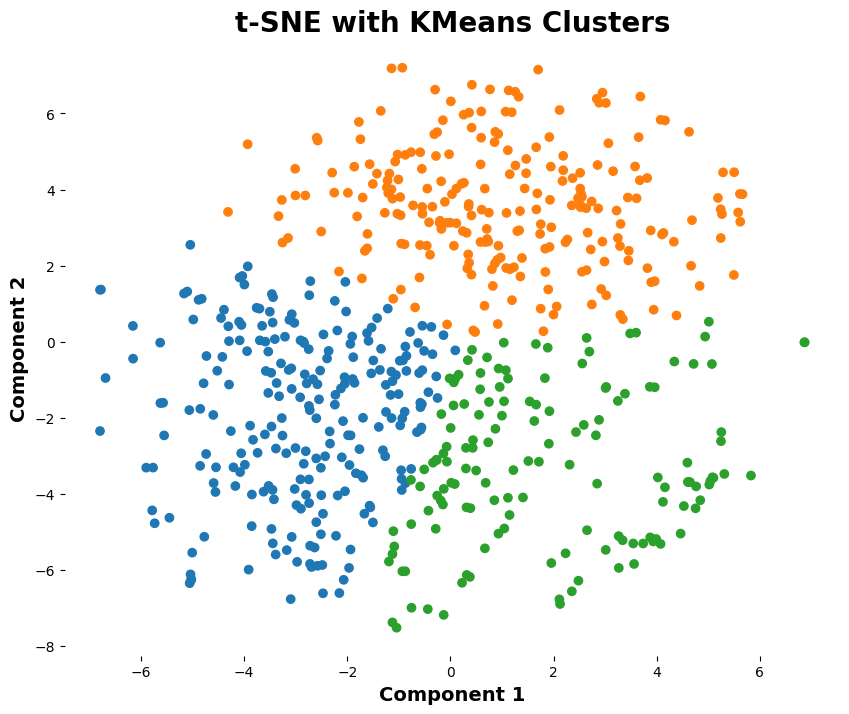

In [198]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, n_init = 'auto', random_state = random_seed)
kmeans.fit(kmeans_df)

labels = kmeans.labels_

tsne_df['Cluster'] = labels
y_train_tsne_cluster = tsne_df['Cluster']

colors = tsne_df['Cluster'].map(cluster_map)

# Plot components with cluster colors
plt.figure(figsize = (10, 8))
plt.title('t-SNE with KMeans Clusters', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', font_dict_axistitle)

plt.show()

# Prediction Model

In [199]:
class ICREnsemble(BaseEstimator):
    def __init__(self):
        self.xgboost = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5)
        self.xgboost_norm = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5)
        self.xgboost_oversample = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5)
        self.xgboost_norm_oversample = XGBClassifier(booster = 'gbtree', tree_method = 'hist', n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5)
        
        self.lightgbm = LGBMClassifier(n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5, reg_alpha = 0.01, reg_lambda = 0.1, verbose = -1)
        self.lightgbm_norm = LGBMClassifier(n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5, reg_alpha = 0.01, reg_lambda = 0.1, verbose = -1)
        self.lightgbm_oversample = LGBMClassifier(n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5, reg_alpha = 0.01, reg_lambda = 0.1, verbose = -1)
        self.lightgbm_norm_oversample = LGBMClassifier(n_estimators = 250, learning_rate = 0.1, max_depth = 6, subsample = 0.5, reg_alpha = 0.01, reg_lambda = 0.1, verbose = -1)
        
        self.xtree = ExtraTreesClassifier(n_estimators = 250, max_features = 0.9, criterion = 'entropy', min_samples_split = 4, min_samples_leaf = 2)
        self.xtree_norm = ExtraTreesClassifier(n_estimators = 250, max_features = 0.9, criterion = 'entropy', min_samples_split = 4, min_samples_leaf = 2)
        self.xtree_oversample = ExtraTreesClassifier(n_estimators = 250, max_features = 0.9, criterion = 'entropy', min_samples_split = 4, min_samples_leaf = 2)
        self.xtree_norm_oversample = ExtraTreesClassifier(n_estimators = 250, max_features = 0.9, criterion = 'entropy', min_samples_split = 4, min_samples_leaf = 2)
        
        self.tabpfn = TabPFNClassifier(N_ensemble_configurations = 64)
        self.tabpfn_norm = TabPFNClassifier(N_ensemble_configurations = 64)
        self.tabpfn_oversample = TabPFNClassifier(N_ensemble_configurations = 64)
        self.tabpfn_norm_oversample = TabPFNClassifier(N_ensemble_configurations = 64)
        
        self.guassian_norm = GaussianProcessClassifier(kernel = 1.0 * RBF(1.0), optimizer = 'fmin_l_bfgs_b', n_restarts_optimizer = 0, max_iter_predict = 500)
        self.guassian_norm_oversample = GaussianProcessClassifier(kernel = 1.0 * RBF(1.0), optimizer = 'fmin_l_bfgs_b', n_restarts_optimizer = 0, max_iter_predict = 500)
               
        self.classifiers_ = [
            ('XGBoost', self.xgboost),
            ('XGBoost Norm', self.xgboost_norm),
            ('XGBoost Oversample', self.xgboost_oversample),
            ('XGBoost Norm Oversample', self.xgboost_norm_oversample),
            
            ('LightGBM', self.lightgbm),
            ('LightGBM Norm', self.lightgbm_norm),
            ('LightGBM Oversample', self.lightgbm_oversample),
            ('LightGBM Norm Oversample', self.lightgbm_norm_oversample),
            
            ('Extra Trees', self.xtree),
            ('Extra Trees Norm', self.xtree_norm),
            ('Extra Trees Oversample', self.xtree_oversample),
            ('Extra Trees Norm Oversample', self.xtree_norm_oversample),
            
            ('TabPFN', self.tabpfn),
            ('TabPFN Norm', self.tabpfn_norm),
            ('TabPFN Oversample', self.tabpfn_oversample),
            ('TabPFN Norm Oversample', self.tabpfn_norm_oversample),
            
            ('Gaussian Norm', self.guassian_norm),
            ('Gaussian Norm Oversample', self.guassian_norm_oversample)
        ]
        
        self.scaler = StandardScaler()
        self.transformer = PowerTransformer()
        self.normalizer = Normalizer()
        
        self.model_predictions = []
        
        self.random_seed = 101010
    
    def fit(self, X, y):
        # normalize
        X_scaled = self.scaler.fit_transform(X)
        X_transformed = self.transformer.fit_transform(X_scaled)
        X_normalized = self.normalizer.fit_transform(X_transformed)
        X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
        y_norm = y.copy()
        
        # oversample
        X_oversampled, y_oversampled = ADASYN(random_state = self.random_seed).fit_resample(X, y)
        
        # normalize oversampled
        X_norm_oversampled, y_norm_oversampled = ADASYN(random_state = self.random_seed).fit_resample(X_norm, y_norm)
        
        # fit
        clases, y = np.unique(y, return_inverse = True)
        self.classes_ = clases
        for model in self.classifiers_:
            if model[0][0:6] == 'TabPFN':
                if model[0][-15:] == 'Norm Oversample':
                    model[1].fit(X_norm_oversampled, y_norm_oversampled, overwrite_warning = True)
                elif model[0][-10:] == 'Oversample':
                    model[1].fit(X_oversampled, y_oversampled, overwrite_warning = True)
                elif model[0][-4:] == 'Norm':
                    model[1].fit(X_norm, y_norm, overwrite_warning = True)
                else:
                    model[1].fit(X, y, overwrite_warning = True)
            else:
                if model[0][-15:] == 'Norm Oversample':
                    model[1].fit(X_norm_oversampled, y_norm_oversampled)
                elif model[0][-10:] == 'Oversample':
                    model[1].fit(X_oversampled, y_oversampled)
                elif model[0][-4:] == 'Norm':
                    model[1].fit(X_norm, y_norm)
                else:
                    model[1].fit(X, y)
                
            
    def predict_proba(self, X, weights = None):
        # normalize
        X_scaled = self.scaler.transform(X)
        X_transformed = self.transformer.transform(X_scaled)
        X_normalized = self.normalizer.transform(X_transformed)
        X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
        
        probabilities = []
        for model in self.classifiers_:
            if model[0][-4:] == 'Norm' or model[0][-15:] == 'Norm Oversample':
                probabilities.append(model[1].predict_proba(X_norm))
                
            else:
                probabilities.append(model[1].predict_proba(X))
                
        probabilities = np.stack(probabilities)
        self.model_predictions = probabilities
        
        if weights is None:
            weights = np.ones(len(self.classifiers_)) / len(self.classifiers_)

        assert len(weights) == probabilities.shape[0], 'weights should have same length as number of classifiers_'

        weighted_probabilities = np.average(probabilities, axis = 0, weights = weights)
            
        y_proba_0 = weighted_probabilities[:, 0 ].sum()
        y_proba_1 = weighted_probabilities[:, 1:].sum()
            
        new_probabilities = weighted_probabilities * np.array([[1/(y_proba_0 if i == 0 else y_proba_1) for i in range(weighted_probabilities.shape[1])]])
            
        return new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
    
    def predict_proba_individual(self, X):
        # normalize
        X_scaled = self.scaler.transform(X)
        X_transformed = self.transformer.transform(X_scaled)
        X_normalized = self.normalizer.transform(X_transformed)
        X_norm = pd.DataFrame(X_normalized, columns = X.columns, index = X.index)
        
        probabilities = []
        probabilities_cols = []
        for model in self.classifiers_:
            if model[0][-4:] == 'Norm' or model[0][-15:] == 'Norm Oversample':
                probabilities.append(model[1].predict_proba(X_norm))
            else:
                probabilities.append(model[1].predict_proba(X))
            
            for class_ in model[1].classes_:
                probabilities_cols.append(model[0] + '_' + str(class_))
        
        return pd.DataFrame(np.concatenate(probabilities, axis = 1), columns = probabilities_cols, index = X.index)
    
    def to_pickel(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)

### Model Evaluation

In [200]:
def model_fit_predict(model_name, model, X_train, y_train, X_test, features):
    X = X_train[features].copy()
    y = y_train.copy()
    test = X_test[features].copy()
    
    if model_name == 'TabPFN':
        model.fit(X, y, overwrite_warning = True)
    else:
        model.fit(X, y)
        
    model_predictions = model.predict_proba(test)
    predictions_df = pd.DataFrame(model_predictions, columns = model.classes_, index = X_test.index)
    predictions_df.columns = [model_name + '_' + str(col) for col in predictions_df.columns]
    if len(predictions_df.columns) == 2:
        predictions_df = predictions_df[[model_name + '_1']]
    
    return predictions_df

In [201]:
def competition_log_loss(y_true, y_pred):
    # calculate the predictin probability, clip it to avoid log(0) and calculate the log loss
    proba_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    proba_0 = np.clip(1 - proba_1, 1e-15, 1 - 1e-15)
    
    # count each class
    class_0 = np.sum(1 - y_true)
    class_1 = np.sum(y_true)

    # log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(proba_0)) / class_0
    log_loss_1 = -np.sum(y_true * np.log(proba_1)) / class_1
    
    # return average log loss
    return (log_loss_0 + log_loss_1)/2

# make scorer for sklearn GridSearchCV
balanced_log_loss_scorer = make_scorer(competition_log_loss, greater_is_better = False, needs_proba = True)

# Model Testing

In [202]:
model = ICREnsemble()

Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters
Loading model that can be used for inference only
Using a Transformer with 25.82 M parameters


In [203]:
prediction_cols = X_train.columns
skf = StratifiedKFold(n_splits = 10, random_state = random_seed, shuffle = True)
ensemble_df = pd.DataFrame({})
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train_alpha)):
    fold, oof = X_train.loc[train_index], X_train.loc[test_index]
    fold_y, oof_y = y_train_class[train_index], y_train_class[test_index]
    
    # fit and predict
    model.fit(fold, fold_y)
    predictions_df = model.predict_proba_individual(oof)

    # combine predictions
    ensemble_df = pd.concat([ensemble_df, predictions_df])

# add meta features
ensemble_df.sort_index(inplace = True)

In [205]:
ensemble_df

,XGBoost_0,XGBoost_1,XGBoost Norm_0,XGBoost Norm_1,XGBoost Oversample_0,XGBoost Oversample_1,XGBoost Norm Oversample_0,XGBoost Norm Oversample_1,LightGBM_0,LightGBM_1,...,TabPFN Norm_0,TabPFN Norm_1,TabPFN Oversample_0,TabPFN Oversample_1,TabPFN Norm Oversample_0,TabPFN Norm Oversample_1,Gaussian Norm_0,Gaussian Norm_1,Gaussian Norm Oversample_0,Gaussian Norm Oversample_1
0,0.266407,0.733593,0.132587,0.867413,0.031728,0.968272,0.012417,0.987583,0.014600,0.985400,...,0.163302,0.836698,0.304159,0.695841,0.308049,0.691951,0.320751,0.679249,0.286614,0.713386
1,0.745304,0.254696,0.827134,0.172866,0.766908,0.233092,0.459641,0.540359,0.918917,0.081083,...,0.288858,0.711142,0.463742,0.536259,0.406146,0.593854,0.462893,0.537107,0.414704,0.585296
2,0.999412,0.000588,0.999746,0.000254,0.999864,0.000136,0.999691,0.000309,0.999997,0.000003,...,0.999718,0.000282,0.999959,0.000041,0.999968,0.000032,0.968132,0.031868,0.904629,0.095371
3,0.992314,0.007686,0.990239,0.009761,0.996580,0.003420,0.991879,0.008121,0.998858,0.001142,...,0.973018,0.026982,0.997534,0.002466,0.996663,0.003337,0.846764,0.153236,0.748284,0.251716
4,0.999086,0.000914,0.985696,0.014304,0.993438,0.006562,0.977481,0.022519,0.999958,0.000042,...,0.995465,0.004536,0.998998,0.001002,0.998566,0.001434,0.929707,0.070293,0.829283,0.170717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,0.636330,0.363670,0.639030,0.360970,0.301220,0.698780,0.155958,0.844042,0.553454,0.446546,...,0.355496,0.644504,0.324829,0.675171,0.501295,0.498705,0.433509,0.566491,0.409013,0.590987
613,0.994823,0.005177,0.994624,0.005376,0.996318,0.003682,0.996167,0.003833,0.998094,0.001906,...,0.994660,0.005340,0.999834,0.000165,0.999561,0.000439,0.906347,0.093653,0.799504,0.200496
614,0.970361,0.029639,0.978027,0.021973,0.928096,0.071904,0.979053,0.020947,0.999872,0.000128,...,0.952955,0.047045,0.767898,0.232102,0.886041,0.113959,0.755315,0.244685,0.648928,0.351072
615,0.997454,0.002546,0.998253,0.001747,0.997273,0.002727,0.998621,0.001379,0.998156,0.001844,...,0.999017,0.000983,0.999907,0.000093,0.999821,0.000179,0.964445,0.035555,0.893936,0.106064


In [207]:
pred_df = ensemble_df.copy()
pred_df = pred_df[pred_df.columns[pred_df.columns.str.contains('_1')]]

In [164]:
pred_df['XGBoost_1']

0      0.854928
1      0.415324
2      0.000402
3      0.006382
4      0.000958
         ...   
612    0.611762
613    0.002309
614    0.031227
615    0.001122
616    0.001904
Name: XGBoost_1, Length: 617, dtype: float64

In [208]:
p_0 = 1 - pred_df['Weighted Average Prediction']
p_1 = pred_df['Weighted Average Prediction']
weighted_probabilities = np.stack([p_0, p_1], axis = 1)
y_proba_0 = weighted_probabilities[:, 0].sum()
y_proba_1 = weighted_probabilities[:, 1].sum()
    
new_probabilities = weighted_probabilities * np.array([[1/(y_proba_0 if i == 0 else y_proba_1) for i in range(weighted_probabilities.shape[1])]])
new_probabilities = new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
y_pred = new_probabilities[:, 1]
competition_log_loss(y_train_class, y_pred)

KeyError: 'Weighted Average Prediction'

In [209]:
pred_df.drop(['Weighted Average Prediction'], axis = 1, inplace = True)

KeyError: "['Weighted Average Prediction'] not found in axis"

In [210]:
from scipy.optimize import minimize
from scipy.special import logit

# Define your objective function: the metric you want to optimize
def objective(weights: np.array, pred_df: pd.DataFrame, y_train_class: np.array):
    ''' Calculate the competition log loss of predictions from a weighted ensemble of models '''
    
    # Normalize weights
    normalized_weights = weights / np.sum(weights)
    
    # Compute the weighted average prediction
    weighted_average_prediction = pred_df.apply(lambda row: np.sum(normalized_weights * row), axis=1)
    
    p_0 = 1 - weighted_average_prediction
    p_1 = weighted_average_prediction
    weighted_probabilities = np.stack([p_0, p_1], axis = 1)
    y_proba_0 = weighted_probabilities[:, 0].sum()
    y_proba_1 = weighted_probabilities[:, 1].sum()
    
    new_probabilities = weighted_probabilities * np.array([[1/(y_proba_0 if i == 0 else y_proba_1) for i in range(weighted_probabilities.shape[1])]])
    new_probabilities = new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
    y_pred = new_probabilities[:, 1]
    
    # Calculate log loss
    log_loss = competition_log_loss(y_train_class, y_pred)  # assuming you have defined `competition_log_loss` elsewhere
    
    # Return log loss
    return log_loss

# Set initial guess (equal weights)
init_guess = [1 / len(pred_df.columns)] * len(pred_df.columns)

# Create bounds and constraints
bounds = [(0, 1) for _ in range(len(pred_df.columns))]
cons = ({'type': 'eq', 'fun': lambda w: 1-sum(w)})

# Run the optimizer
result = minimize(objective, init_guess, args=(pred_df, y_train_class), method='SLSQP', bounds=bounds, constraints=cons)

# Get the optimal weights
optimal_weights = result.x

In [211]:
optimal_weights

array([4.44782865e-17, 0.00000000e+00, 7.22892824e-17, 8.06915763e-02,
       3.47199543e-01, 0.00000000e+00, 3.08883939e-01, 1.08519733e-17,
       2.56547450e-17, 2.41300364e-18, 0.00000000e+00, 7.04931082e-18,
       2.56897423e-17, 2.38160009e-17, 2.51395945e-01, 4.57172248e-17,
       0.00000000e+00, 1.18289958e-02])

In [213]:
np.array([5.14835208e-17, 1.48101772e-16, 2.55549331e-01, 5.25003200e-17,
       4.85112434e-01, 3.35015415e-17, 8.56607476e-17, 5.49224899e-02,
       4.74055469e-17, 3.16468402e-17, 0.00000000e+00, 2.61679472e-17,
       3.22685072e-17, 0.00000000e+00, 1.91632495e-01, 3.83244282e-19,
       3.11089324e-17, 1.27832496e-02])

array([5.14835208e-17, 1.48101772e-16, 2.55549331e-01, 5.25003200e-17,
       4.85112434e-01, 3.35015415e-17, 8.56607476e-17, 5.49224899e-02,
       4.74055469e-17, 3.16468402e-17, 0.00000000e+00, 2.61679472e-17,
       3.22685072e-17, 0.00000000e+00, 1.91632495e-01, 3.83244282e-19,
       3.11089324e-17, 1.27832496e-02])

In [214]:
weighted_average_prediction = pred_df.apply(lambda row: np.sum(optimal_weights * row), axis=1)

p_0 = 1 - weighted_average_prediction
p_1 = weighted_average_prediction
weighted_probabilities = np.stack([p_0, p_1], axis = 1)
y_proba_0 = weighted_probabilities[:, 0].sum()
y_proba_1 = weighted_probabilities[:, 1].sum()

new_probabilities = weighted_probabilities * np.array([[1/(y_proba_0 if i == 0 else y_proba_1) for i in range(weighted_probabilities.shape[1])]])
new_probabilities = new_probabilities / np.sum(new_probabilities, axis = 1, keepdims = 1)
y_pred = new_probabilities[:, 1]

# Calculate log loss
competition_log_loss(y_train_class, y_pred)  # assuming you have defined `competition_log_loss` elsewhere

0.17532459180036863

In [178]:
y_pred

array([0.99031321, 0.60364647, 0.00722862, 0.04456885, 0.03148682,
       0.01966496, 0.01312083, 0.94432828, 0.01451222, 0.11727726,
       0.99899232, 0.08008727, 0.28016914, 0.02980664, 0.02079052,
       0.23219925, 0.01389438, 0.01106532, 0.01253854, 0.03037427,
       0.33467487, 0.09223459, 0.03246223, 0.62917643, 0.87851076,
       0.01243456, 0.02696804, 0.83310308, 0.03346824, 0.00819287,
       0.99827258, 0.00910577, 0.0436804 , 0.14681999, 0.02731902,
       0.00993686, 0.13731595, 0.99274555, 0.01245058, 0.06787939,
       0.13408586, 0.01224981, 0.33852692, 0.05793067, 0.00773152,
       0.14258488, 0.00778935, 0.01301022, 0.2273164 , 0.04634361,
       0.02689196, 0.01585188, 0.05910081, 0.04381153, 0.0103441 ,
       0.01594157, 0.386349  , 0.40195765, 0.00854948, 0.95823539,
       0.98734804, 0.01393537, 0.13671767, 0.99422609, 0.36658549,
       0.01518436, 0.0266642 , 0.0189091 , 0.0118872 , 0.01093333,
       0.89176711, 0.01028098, 0.00561518, 0.80590946, 0.04487

In [159]:
model_prediction_cols = ensemble_df.columns.to_list()
ensemble_df['Class'] = y_train_class

for col in model_prediction_cols:
    print(col)
    print('ROC AUC:', roc_auc_score(ensemble_df['Class'], ensemble_df[col]))
    print('Log Loss:', competition_log_loss(ensemble_df['Class'], ensemble_df[col]))

XGBoost_0
ROC AUC: 0.0275049115913556
Log Loss: 3.8681736644667293
XGBoost_1
ROC AUC: 0.9724950884086444
Log Loss: 0.3653076854875811
XGBoost Norm_0
ROC AUC: 0.028887433602561307
Log Loss: 3.7229279002588576
XGBoost Norm_1
ROC AUC: 0.9711125663974387
Log Loss: 0.38597380207509496
XGBoost Oversample_0
ROC AUC: 0.026176962817434327
Log Loss: 4.094329714998659
XGBoost Oversample_1
ROC AUC: 0.9738230371825656
Log Loss: 0.24957949913413266
XGBoost Norm Oversample_0
ROC AUC: 0.03176162409954158
Log Loss: 4.020344355090093
XGBoost Norm Oversample_1
ROC AUC: 0.9682383759004585
Log Loss: 0.2926941280797623
LightGBM_0
ROC AUC: 0.02459433893618568
Log Loss: 5.913068306954485
LightGBM_1
ROC AUC: 0.9754056610638143
Log Loss: 0.4320887718244462
LightGBM Norm_0
ROC AUC: 0.029724223240922654
Log Loss: 5.74377217258238
LightGBM Norm_1
ROC AUC: 0.9702757767590774
Log Loss: 0.5270044525918351
LightGBM Oversample_0
ROC AUC: 0.028523612020665053
Log Loss: 6.196262300154167
LightGBM Oversample_1
ROC AUC: 0.

In [140]:
model_prediction_cols = ensemble_df.columns.to_list()
ensemble_df['Class'] = y_train_class

for col in model_prediction_cols:
    print(col)
    print('ROC AUC:', roc_auc_score(ensemble_df['Class'], ensemble_df[col]))
    print('Log Loss:', competition_log_loss(ensemble_df['Class'], ensemble_df[col]))

roc_auc = []
log_loss = []
    
def row_log_loss(row):
    if row['Class'] == 0:
        return -np.log(1 - row['Ensemble_1'])
    else:
        return -np.log(row['Ensemble_1'])
    
ensemble_df['Log Loss'] = ensemble_df.apply(row_log_loss, axis = 1)

def classify_error_types(row):
    if row['Class'] == 0 and row['Ensemble_1'] > 0.5:
        return 'False Positive'
    elif row['Class'] == 1 and row['Ensemble_1'] < 0.5:
        return 'False Negative'
    elif row['Class'] == 0 and row['Ensemble_1'] < 0.5:
        return 'True Negative'
    elif row['Class'] == 1 and row['Ensemble_1'] >= 0.5:
        return 'True Positive'
    
ensemble_df['Error Type'] = ensemble_df.apply(classify_error_types, axis = 1)
y_train_error_type = ensemble_df['Error Type']

for col in model_prediction_cols:
    print(col)
    print('ROC AUC:', roc_auc_score(ensemble_df['Class'], ensemble_df[col]))
    print('Log Loss:', competition_log_loss(ensemble_df['Class'], ensemble_df[col]))

ensemble_df.sort_values(by = 'Log Loss', ascending = False).head(25)

KeyError: 'Ensemble_1'

In [ ]:
model.model_predictions

In [ ]:
1000 // 14

In [ ]:
loss = 0.1536790084666712
model = WeightedEnsemble()
best_model = None
counter = 0
while loss > 0 and counter < 100:
    counter += 1
    
    X, X_val, y, y_val = train_test_split(X_train, y_train_class, test_size = 0.3, stratify = y_train_splitter)
    X, y = ADASYN().fit_resample(X, y)
    
    model.fit(X, y)
    y_pred = model.predict_proba(X_val)[:, 1]
    split_loss = competition_log_loss(y_val, y_pred)
        
    if split_loss < loss:
        loss = split_loss
        best_model = model
        best_model.to_pickel('best_model.pkl')
        print('New Best Loss: ', loss)
        counter = 0
        
    if counter == 500:
        print('No improvement in ', counter, ' iterations')
        print('Best Loss: ', loss)
    
    if counter % 10 == 0 and counter != 0:
        print('No improvement in ', counter, ' iterations')
    

### Important Featues

In [ ]:
best_model = pd.read_pickle('best_model.pkl')

In [ ]:
X_train['Sum'] = X_train.sum(axis = 1)

In [ ]:
X_train['Sum'].describe()

In [ ]:
best_model

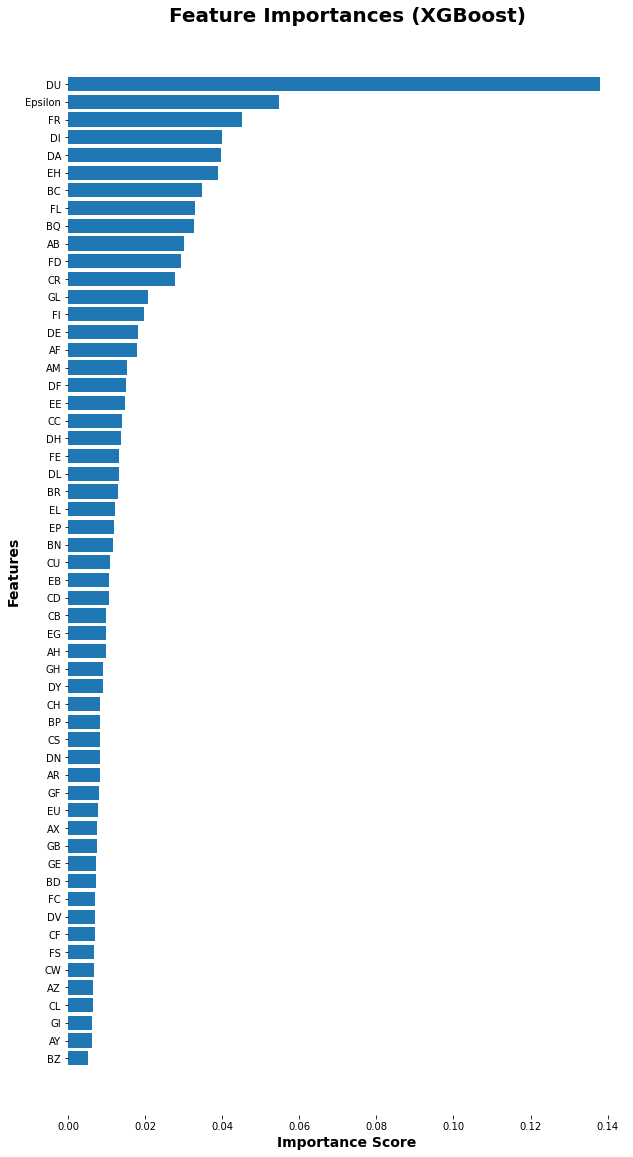

In [367]:
xgb = model.classifiers_[3][1]
importances = pd.Series(xtree.feature_importances_, index = X_train.columns).sort_values(ascending = True)

plt.figure(figsize = (10, 20))
plt.title('Feature Importances (XGBoost)', fontdict = font_dict_header)
plt.box(False)
plt.barh(importances.index, importances.values)
plt.xlabel('Importance Score', fontdict = font_dict_axistitle)
plt.ylabel('Features', fontdict = font_dict_axistitle)
plt.show()

### Visualize Errors

In [ ]:
class_color_map = {0: 'C0', 1: 'C1'}
alpha_color_map = {'A': 'C0', 'B': 'C1', 'D': 'C2', 'G': 'C3'}
error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C2', 'False Negative': 'C3'}

In [ ]:
# TSNE
tsne_n = 2
tsne_df = X_train.drop(['Epsilon'], axis = 1, inplace = False)
tsne = TSNE(n_components = tsne_n, random_state = random_seed) 
tsne_columns = ['Component ' + str(i + 1) for i in range(tsne_n)]
x_tsne = tsne.fit_transform(tsne_df)

# create df with the t-SNE components and 'Class'
tsne_df = pd.DataFrame(data = x_tsne, columns = tsne_columns)
tsne_df['Class'] = y_train_class
tsne_df['Error Type'] = y_train_error_type

error_type_map = {'True Positive': 'C0', 'True Negative': 'C1', 'False Positive': 'C3', 'False Negative': 'C4'}
colors = tsne_df['Error Type'].map(error_type_map)

# map error types to sizes
size_map = {'True Positive': 30, 'True Negative': 30, 'False Positive': 200, 'False Negative': 200}
sizes = tsne_df['Error Type'].map(size_map)

legend_elements = [Patch(color=clr, label=lbl) for lbl, clr in error_type_map.items()]

# plot components
plt.figure(figsize = (10, 8))
plt.title('t-SNE', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors, s = sizes)
plt.legend(handles = legend_elements, loc = 'upper right', fontsize = 12)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', fontdict = font_dict_axistitle)

plt.show()


In [ ]:
# We will only use the components for clustering
X = tsne_df[tsne_columns]

# Range of clusters
range_clusters = range(1, 10)

# List to hold the WCSS for each number of clusters
wcss = []

for i in range_clusters:
    kmedoids = KMeans(n_clusters = i, n_init = 'auto', random_state = random_seed)
    kmedoids.fit(X)
    wcss.append(kmedoids.inertia_)

plt.figure(figsize = (10, 8))
plt.title('The Elbow Method', fontdict = font_dict_header)
plt.box(False)
plt.plot(range_clusters, wcss)
plt.xlabel('Number of Clusters', fontdict = font_dict_axistitle)
plt.ylabel('WCSS', fontdict = font_dict_axistitle)

plt.show()

In [ ]:
y_train_tsne_cluster = tsne_df['Cluster']

In [ ]:
# Define KMeans with 3 clusters
n_clusters = 4
kmeans = KMeans(n_clusters = n_clusters, n_init = 'auto', random_state = random_seed)
kmeans.fit(X)

# get the labels of clusters
labels = kmeans.labels_

# Adding cluster labels to our tsne dataframe
tsne_df['Cluster'] = labels
y_train_tsne_cluster = tsne_df['Cluster']

# Create color map for clusters
cluster_map = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3', 4: 'C4', 5: 'C5', 6: 'C6'}
colors = tsne_df['Cluster'].map(cluster_map)

# Redefine size map to add the sizes for clusters
size_map = {'True Positive': 30, 'True Negative': 30, 'False Positive': 200, 'False Negative': 200}
sizes = tsne_df['Error Type'].map(size_map)

# Plot components with cluster colors
plt.figure(figsize = (10, 8))
plt.title('t-SNE with KMeans Clusters', fontdict = font_dict_header)
plt.box(False)
plt.scatter(tsne_df['Component 1'], tsne_df['Component 2'], c = colors, s = sizes)
plt.xlabel('Component 1', fontdict = font_dict_axistitle)
plt.ylabel('Component 2', font_dict_axistitle)

plt.show()

In [ ]:
X_clusters = {}
y_clusters = {}

for i in range(n_clusters):
    X_clusters[i] = X_train[y_train_tsne_cluster == i]
    y_clusters[i] = y_train_class[y_train_tsne_cluster == i]


# Submission

In [ ]:
def prediction_pipeline(X, features):
    # pre-process
    X = X.copy()
    X.columns = X.columns.str.strip()
    X['Epsilon'] = X_train['Epsilon'].max() + 1
    X = X[features]
    imputed = median_imputer.transform(X)
    X = pd.DataFrame(imputed, columns = X.columns, index = X.index)
    
    # fit model and predict
    model.fit(X_train, y_train_class)
    X[['class_0', 'class_1']] = model.predict_proba(X)
    
    return X

In [ ]:
X_test = prediction_pipeline(test_df, prediction_cols)

In [ ]:
submission_df = pd.concat([test_df[['Id']], X_test[['class_0', 'class_1']]], axis = 1)
submission_df.to_csv('submission.csv', index = False)
submission_df

In [291]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures

In [39]:
from lightgbm import LGBMClassifier

In [118]:
xtree = ExtraTreesClassifier(random_state=random_seed)

parameters = {
    'n_estimators': [250],
    'max_features': [0.9],
    'criterion': ['entropy'],
    'min_samples_split': [4],
    'min_samples_leaf': [2]
}

xtree = ExtraTreesClassifier(n_estimators = 250, max_features = 0.9, criterion = 'entropy', min_samples_split = 4, min_samples_leaf = 2)

X_scaled = StandardScaler().fit_transform(X_train)
X_transformed = PowerTransformer().fit_transform(X_scaled)
X_norm_normalized = Normalizer().fit_transform(X_transformed)
X_norm = pd.DataFrame(X_norm_normalized, columns = X_train.columns, index = X_train.index)
X_test = X_train.drop(['DU'], axis = 1, inplace = False)

grid_obj = GridSearchCV(xtree, parameters, scoring = balanced_log_loss_scorer, cv = 5)
grid_obj = grid_obj.fit(X_test, y_train_class)
xtree = grid_obj.best_estimator_
xtree.fit(X_test, y_train_class)

ExtraTreesClassifier(criterion='entropy', max_features=0.9, min_samples_leaf=2,
                     min_samples_split=4, n_estimators=250,
                     random_state=101010)

In [119]:
results = pd.DataFrame(grid_obj.cv_results_)
results.sort_values('rank_test_score', inplace = True)
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.309921,0.034169,0.010241,0.00048,entropy,0.9,2,4,250,"{'criterion': 'entropy', 'max_features': 0.9, ...",-0.396332,-0.392555,-0.435123,-0.451047,-0.411244,-0.41726,0.022562,1


In [114]:
lgbm.predict_proba(X_train)

array([[7.36183241e-04, 9.99263817e-01],
       [1.81057920e-03, 9.98189421e-01],
       [9.99997419e-01, 2.58141344e-06],
       ...,
       [9.99896711e-01, 1.03289057e-04],
       [9.99978727e-01, 2.12726789e-05],
       [9.99926534e-01, 7.34658255e-05]])